In [1]:
# 내용 import
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Layer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import font_manager
import json
from concurrent.futures import ProcessPoolExecutor


2024-12-18 05:52:24.771499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 05:52:24.985038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 05:52:25.112862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 05:52:25.140800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 05:52:25.270844: I tensorflow/core/platform/cpu_feature_guar

In [2]:
## 데이터 전처리 및 로드
# 데이터 전처리 함수
# 데이터 전처리 함수: 가변 길이 및 background 라벨 건너뛰기
def process_single_file(file_path):
    try:
        df = pd.read_csv(
            file_path,
            usecols=['frame_num', 'landmark_type', 'index', 'x', 'y', 'z', 'label'],
            dtype={
                'frame_num': 'int32',
                'landmark_type': 'category',
                'index': 'int8',
                'x': 'float32',
                'y': 'float32',
                'z': 'float32',
                'label': 'category'
            }
        )
        df = df.sort_values(by=['frame_num']).reset_index(drop=True)
        grouped = df.groupby('frame_num')

        sequences, labels = [], []
        current_sequence = []
        current_label = None

        for frame_num, group in grouped:
            label = group['label'].iloc[0]

            # background 클래스는 건너뛰기
            if label == "background":
                continue

            # 시퀀스 시작 또는 라벨 변경 시 처리
            if current_label is None:
                current_label = label
            elif label != current_label:
                # 현재 시퀀스 저장
                if len(current_sequence) > 0:
                    sequences.append(np.array(current_sequence))
                    labels.append(current_label)
                current_sequence = []
                current_label = label

            # 프레임 데이터를 저장
            frame_data = {
                'pose': np.zeros((33, 3), dtype=np.float32),
                'left_hand': np.zeros((21, 3), dtype=np.float32),
                'right_hand': np.zeros((21, 3), dtype=np.float32)
            }
            for _, row in group.iterrows():
                landmark_type = row['landmark_type']
                index = row['index']
                coords = [row['x'], row['y'], row['z']]
                if landmark_type in frame_data:
                    frame_data[landmark_type][index] = coords

            concatenated_data = np.concatenate([
                frame_data['pose'],
                frame_data['left_hand'],
                frame_data['right_hand']
            ], axis=0)
            current_sequence.append(concatenated_data)

        # 마지막 시퀀스 저장 (길이 제한 없이)
        if len(current_sequence) > 0:
            sequences.append(np.array(current_sequence))
            labels.append(current_label)

        return sequences, labels

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []
    
# -----------------------------
# 데이터 전처리 및 멀티프로세싱
# -----------------------------
def load_and_process_data(data_folder):
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

    all_sequences, all_labels = [], []
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_single_file, csv_files), total=len(csv_files), desc="파일 처리 중"))
        for sequences, labels in results:
            all_sequences.extend(sequences)
            all_labels.extend(labels)

    return all_sequences, all_labels


data_folder = r'/mnt/c/Users/SBS/Desktop/WorkSpace/SignLanguageModel/data/labeled_keypoints'
all_sequences, all_labels = load_and_process_data(data_folder)


파일 처리 중: 100%|██████████| 89833/89833 [31:15<00:00, 47.90it/s]  


In [ ]:
import random
# -----------------------------
# 언더샘플링 및 데이터 증강 함수
# -----------------------------
def balance_data(sequences, labels, max_samples_per_class=1000):
    """
    데이터를 클래스별로 균형 있게 만들기 위해 언더샘플링과 증강을 수행.
    
    Args:
        sequences: 시계열 데이터 리스트
        labels: 라벨 리스트
        max_samples_per_class: 클래스당 최대 샘플 수
    
    Returns:
        balanced_sequences: 균형 잡힌 시계열 데이터
        balanced_labels: 균형 잡힌 라벨
    """
    data = pd.DataFrame({"sequence": sequences, "label": labels})
    balanced_sequences = []
    balanced_labels = []

    # 클래스별 데이터 그룹화
    grouped = data.groupby("label")
    
    for label, group in grouped:
        if len(group) > max_samples_per_class:
            # 언더샘플링
            sampled = group.sample(n=max_samples_per_class, random_state=42)
        else:
            # 데이터 증강
            sampled = group.copy()
            while len(sampled) < max_samples_per_class:
                # 원본 데이터를 반복적으로 추가
                sampled = pd.concat([sampled, group])
            # 초과된 샘플 제거
            sampled = sampled.sample(n=max_samples_per_class, random_state=42)

        # 증강 작업: 데이터에 노이즈 추가
        for _, row in sampled.iterrows():
            sequence = row["sequence"]
            if random.random() > 0:  # 50% 확률로 노이즈 추가
                augmented_sequence = sequence + np.random.normal(0, 0.01, sequence.shape)
                balanced_sequences.append(augmented_sequence)
            else:
                balanced_sequences.append(sequence)
            balanced_labels.append(label)

    return balanced_sequences, balanced_labels

max_samples_per_class = 200
print("언더샘플링 및 증강 적용 중...")
balanced_sequences, balanced_labels = balance_data(all_sequences, all_labels, max_samples_per_class)
print(f"언더샘플링 및 증강 적용 완료 \n 클래스당 샘플 개수 :{max_samples_per_class}")

언더샘플링 및 증강 적용 중...
언더샘플링 및 증강 적용 완료 
 클래스당 샘플 개수 :300


In [12]:
# 언더 샘플링만 하는경우
import pandas as pd
import numpy as np
import random

def balance_data(sequences, labels, max_samples_per_class=1000):
    """
    데이터를 클래스별로 균형 있게 만들기 위해 언더샘플링만 수행.
    
    Args:
        sequences: 시계열 데이터 리스트(또는 배열)
        labels: 라벨 리스트
        max_samples_per_class: 클래스당 최대 샘플 수
    
    Returns:
        balanced_sequences: 균형 잡힌 시계열 데이터
        balanced_labels: 균형 잡힌 라벨
    """
    data = pd.DataFrame({"sequence": sequences, "label": labels})
    balanced_sequences = []
    balanced_labels = []

    # 클래스별 데이터 그룹화
    grouped = data.groupby("label")
    
    for label, group in grouped:
        if len(group) > max_samples_per_class:
            # 언더샘플링 수행
            sampled = group.sample(n=max_samples_per_class, random_state=42)
        else:
            # 증강 없이 원본 데이터를 그대로 사용
            sampled = group
        
        for _, row in sampled.iterrows():
            sequence = row["sequence"]
            balanced_sequences.append(sequence)
            balanced_labels.append(label)

    return balanced_sequences, balanced_labels

max_samples_per_class = 300
print("언더샘플링만 적용 중...")
balanced_sequences, balanced_labels = balance_data(all_sequences, all_labels, max_samples_per_class)
print(f"언더샘플링 적용 완료\n클래스당 샘플 개수: {max_samples_per_class}")


언더샘플링만 적용 중...
언더샘플링 적용 완료
클래스당 샘플 개수: 300


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# -----------------------------
# 패딩 적용 전: 시퀀스 데이터 평탄화 (3차원으로 변환)
# -----------------------------
print("데이터 차원 변환 중...")

# 각 시퀀스의 프레임 데이터를 (75, 3) -> (225)로 변환
balanced_sequences_flat = [seq.reshape(seq.shape[0], -1) for seq in balanced_sequences]

print("데이터 차원 변환 완료!")
print(f"예시 시퀀스 형태: {balanced_sequences_flat[0].shape}")  # (timesteps, 225)

# -----------------------------
# 패딩 적용
# -----------------------------
print("패딩 적용 중...")

# 최대 시퀀스 길이 계산
MAX_SEQUENCE_LENGTH = max(len(seq) for seq in balanced_sequences_flat)

# 시퀀스에 패딩 적용
balanced_sequences_padded = pad_sequences(
    balanced_sequences_flat, 
    maxlen=MAX_SEQUENCE_LENGTH, 
    dtype='float32', 
    padding='post', 
    value=0.0
)

# NumPy 배열로 변환
balanced_sequences_padded = np.array(balanced_sequences_padded, dtype='float32')
balanced_labels = np.array(balanced_labels)

print("패딩 적용 완료!")
print(f"패딩된 시퀀스 형태: {balanced_sequences_padded.shape}")


데이터 차원 변환 중...
데이터 차원 변환 완료!
예시 시퀀스 형태: (32, 225)
패딩 적용 중...
패딩 적용 완료!
패딩된 시퀀스 형태: (62244, 91, 225)


In [14]:
import numpy as np

# 클래스 개수 확인
unique_classes = np.unique(balanced_labels)  # 고유 클래스 값 찾기
num_classes = len(unique_classes)  # 고유 클래스 개수

print("클래스의 개수:", num_classes)
print("클래스 라벨:", unique_classes)

클래스의 개수: 321
클래스 라벨: [' 알려주다' '1' '10분' '119' '12' '12시' '1시' '1시간' '1호' '1회' '2호' '3' '3시'
 '3호' '40분' '4사람' '50분' '5분' '5호' '8호' '9호' '가깝다' '가능' '가다' '가방' '갈아타다'
 '감사합니다' '강남' '건너다' '경찰' '계단' '계산' '고속' '고속터미널' '고장' '곳' '곳곳' '공기청정기' '공항'
 '괜찮다' '교통카드' '교환하다' '국립박물관' '군청' '그남자' '그만' '급하다' '기다리다' '기본' '기차' '길'
 '까먹다' '꼿다' '끄다' '끝' '나' '나르다' '나사렛' '난방' '남다' '내리다' '내역' '냄새' '노트북' '누구'
 '누적사용' '늦다' '다르다' '다시' '다음' '단말기터치' '당신' '대략' '대로' '도와주다' '도움받다' '도착' '돈'
 '돈받다' '돈얼마' '돈주다' '되다' '뒤' '들어올리다' '따뜻하다' '딱' '떨어지다' '또' '롯데월드' '마포대교'
 '막차' '만나다' '만원' '말하다' '말해주다' '맞다' '맥도날드' '명동' '몇분' '몇사람' '몇호' '모르다' '목적'
 '무엇' '문' '문안열리다' '문자받다' '문자보내다' '물건' '물품보관' '미리' '미안합니다' '바꾸다' '반갑다' '반대'
 '반지' '받다' '발생하다' '밤' '방법' '방황' '배' '백화점' '버스' '번호' '병원' '보건소' '보관' '보다'
 '보여주다' '보청기' '부르다' '분당' '불가능' '불량' '불편하다' '빨리' '뼈곳' '사거리' '사다' '사라지다'
 '사람' '사용' '사진기' '샛길' '서대문농아인복지관' '서울' '서울농아인협회' '서울대학교' '서울역' '설명'
 '손바닥찍다' '송파' '수고' '스타벅스' '시간' '시계' '시청' '신고' '신분당' '신분증' '신촌' '신호동' '신호등'
 '실수하다' '실종' '심하다' '쓰러지다' '아니다' 

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# -----------------------------
# 4. 라벨 인코딩 (원-핫 인코딩)
# -----------------------------
print("라벨을 원-핫 인코딩 중...")

# 라벨을 원-핫 인코딩
y = pd.get_dummies(balanced_labels).values  # 원-핫 인코딩된 라벨 (num_sequences, num_classes)
label_names = pd.get_dummies(balanced_labels).columns.tolist()  # 클래스 이름 리스트

print(f"클래스 개수: {len(label_names)}")
print(f"클래스 이름: {label_names}")

# -----------------------------
# 5. 데이터 상태 점검 및 타입 변환
# -----------------------------

print("데이터 상태를 점검 중...")

# 입력 데이터 (X) 상태 확인
print("X 데이터 결측값 확인:", np.isnan(balanced_sequences_padded).any())
print("X 데이터 무한값 확인:", np.isinf(balanced_sequences_padded).any())

# 결측값 및 무한값 처리
balanced_sequences_padded = np.nan_to_num(balanced_sequences_padded, nan=0.0, posinf=0.0, neginf=0.0)

# 라벨 데이터 (y) 타입 변환
y = y.astype('float32')

print("X 데이터 타입:", balanced_sequences_padded.dtype)
print("y 데이터 타입:", y.dtype)

# -----------------------------
# 6. 데이터 분할 (훈련/테스트)
# -----------------------------
print("데이터를 훈련 세트와 테스트 세트로 분할 중...")

# 데이터셋 분할: 훈련 80%, 테스트 20%
X_train, X_test, y_train, y_test = train_test_split(
    balanced_sequences_padded, y, test_size=0.2, random_state=42, stratify=balanced_labels
)

# 데이터 타입 확인 및 변환
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# -----------------------------
# 7. 클래스 불균형 확인
# -----------------------------
print("클래스별 샘플 개수 확인...")
train_labels_count = y_train.sum(axis=0)
test_labels_count = y_test.sum(axis=0)

# 클래스별 개수 출력
for idx, label in enumerate(label_names):
    print(f"클래스 '{label}': 훈련 세트 {int(train_labels_count[idx])}개, 테스트 세트 {int(test_labels_count[idx])}개")

# -----------------------------
# 8. 최종 데이터 상태 출력
# -----------------------------
print(f"훈련 샘플 수: {len(X_train)}, 테스트 샘플 수: {len(X_test)}")
print(f"훈련 데이터 형태: {X_train.shape}, 테스트 데이터 형태: {X_test.shape}")
print(f"훈련 라벨 형태: {y_train.shape}, 테스트 라벨 형태: {y_test.shape}")

# 클래스 이름들 값 출력 Json으로
label_names_json = json.dumps(label_names, indent=4, ensure_ascii=False)

# JSON 파일로 저장
with open("class_names_GRU.json", "w", encoding="utf-8") as json_file:
    json_file.write(label_names_json)

print("클래스 이름이 JSON 파일로 저장되었습니다.")
print(label_names_json)  # 출력 확인



라벨을 원-핫 인코딩 중...
클래스 개수: 321
클래스 이름: [' 알려주다', '1', '10분', '119', '12', '12시', '1시', '1시간', '1호', '1회', '2호', '3', '3시', '3호', '40분', '4사람', '50분', '5분', '5호', '8호', '9호', '가깝다', '가능', '가다', '가방', '갈아타다', '감사합니다', '강남', '건너다', '경찰', '계단', '계산', '고속', '고속터미널', '고장', '곳', '곳곳', '공기청정기', '공항', '괜찮다', '교통카드', '교환하다', '국립박물관', '군청', '그남자', '그만', '급하다', '기다리다', '기본', '기차', '길', '까먹다', '꼿다', '끄다', '끝', '나', '나르다', '나사렛', '난방', '남다', '내리다', '내역', '냄새', '노트북', '누구', '누적사용', '늦다', '다르다', '다시', '다음', '단말기터치', '당신', '대략', '대로', '도와주다', '도움받다', '도착', '돈', '돈받다', '돈얼마', '돈주다', '되다', '뒤', '들어올리다', '따뜻하다', '딱', '떨어지다', '또', '롯데월드', '마포대교', '막차', '만나다', '만원', '말하다', '말해주다', '맞다', '맥도날드', '명동', '몇분', '몇사람', '몇호', '모르다', '목적', '무엇', '문', '문안열리다', '문자받다', '문자보내다', '물건', '물품보관', '미리', '미안합니다', '바꾸다', '반갑다', '반대', '반지', '받다', '발생하다', '밤', '방법', '방황', '배', '백화점', '버스', '번호', '병원', '보건소', '보관', '보다', '보여주다', '보청기', '부르다', '분당', '불가능', '불량', '불편하다', '빨리', '뼈곳', '사거리', '사다', '사라지다', '사람', '사용', '사진기', '샛길', '서대

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# -----------------------------
# GRU 모델 구축
# -----------------------------
print("GRU 모델을 구축 중...")
model = Sequential()

# Input 레이어 추가 (가변 길이 입력 처리)
model.add(Input(shape=(None, X_train.shape[2])))

# Masking 레이어 (패딩이 있는 경우 무시)
model.add(Masking(mask_value=0.0))

# 첫 번째 GRU 레이어
model.add(GRU(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 두 번째 GRU 레이어
model.add(GRU(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 출력 레이어 (소프트맥스 활성화)
model.add(Dense(y.shape[1], activation='softmax'))

# 모델 컴파일
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


# -----------------------------
# 9. 콜백 함수 설정
# -----------------------------
# 콜백 함수 설정 (파일 확장자를 .keras로 변경)
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]


# -----------------------------
# 10. 모델 학습
# -----------------------------
batch_size = 32
epochs = 100

print("모델 학습 시작...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


# 모델 학습 후 세션 초기화
tf.keras.backend.clear_session()
print("TensorFlow 세션 초기화 완료. GPU 메모리가 해제되었습니다.")

GRU 모델을 구축 중...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 225)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 64)       │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 321)            │        20,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,209 (399.25 KB)

 Trainable params: 101,953 (398.25 KB)

 Non-trainable params: 256 (1.00 KB)

모델 학습 시작...
Epoch 1/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.0072 - loss: 5.7876 - val_accuracy: 0.0355 - val_loss: 5.2061
Epoch 2/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.0278 - loss: 5.2369 - val_accuracy: 0.0652 - val_loss: 4.8143
Epoch 3/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.0584 - loss: 4.8550 - val_accuracy: 0.1170 - val_loss: 4.4221
Epoch 4/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.1016 - loss: 4.4964 - val_accuracy: 0.1864 - val_loss: 4.0125
Epoch 5/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.1593 - loss: 4.1259 - val_accuracy: 0.2751 - val_loss: 3.6209
Epoch 6/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.2152 - loss: 3.7651 - val_accuracy: 0.3129 - val_loss: 3.3093
Epoch 7/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.2746 - loss: 3.4479 - val_accuracy: 0.4120 - val_loss: 2.9437
Epoch 8/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step 

In [18]:
from tensorflow.keras.models import load_model
# -----------------------------
# 11. 모델 평가
# -----------------------------

print("베스트 모델을 로드 중...")
# 학습된 베스트 모델 불러오기
best_model = load_model(r'/mnt/c/Users/SBS/Desktop/WorkSpace/SignLanguageModel/bestGRU_model.keras')
print("베스트 모델이 성공적으로 로드되었습니다.")

import numpy as np

# 모델 예측
y_pred = model.predict(X_test)  # 클래스별 확률값 반환

# 각 샘플에서 가장 확률이 높은 클래스 인덱스 찾기
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 라벨 인덱스 (원-핫 인코딩된 y_test를 다시 클래스 인덱스로 변환)
y_true_classes = np.argmax(y_test, axis=1)

# 출력 확인
print("예측된 클래스 인덱스:", y_pred_classes[:10])
print("실제 클래스 인덱스:", y_true_classes[:10])


베스트 모델을 로드 중...
베스트 모델이 성공적으로 로드되었습니다.
390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
예측된 클래스 인덱스: [ 57  82 225  29   3 306 157 126 119 320]
실제 클래스 인덱스: [ 57 152 225  29   3 306  73 126 119 320]


결과를 시각화 중...
분류 보고서를 출력합니다:
              precision    recall  f1-score   support

        알려주다       0.00      0.00      0.00         1
           1       0.53      0.50      0.51        18
         10분       0.67      0.83      0.74        36
         119       0.96      0.92      0.94        60
          12       0.76      0.72      0.74        36
         12시       0.75      0.67      0.71        18
          1시       0.94      0.83      0.88        18
         1시간       0.95      1.00      0.97        18
          1호       0.75      0.92      0.83        60
          1회       1.00      0.22      0.36        18
          2호       1.00      1.00      1.00        18
           3       0.86      1.00      0.92        60
          3시       0.94      0.89      0.91        18
          3호       0.94      0.83      0.88        18
         40분       0.83      0.29      0.43        17
         4사람       0.65      1.00      0.79        17
         50분       1.00      0.22      0.36         9

/home/beom710/miniconda3/envs/sign/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beom710/miniconda3/envs/sign/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/beom710/miniconda3/envs/sign/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

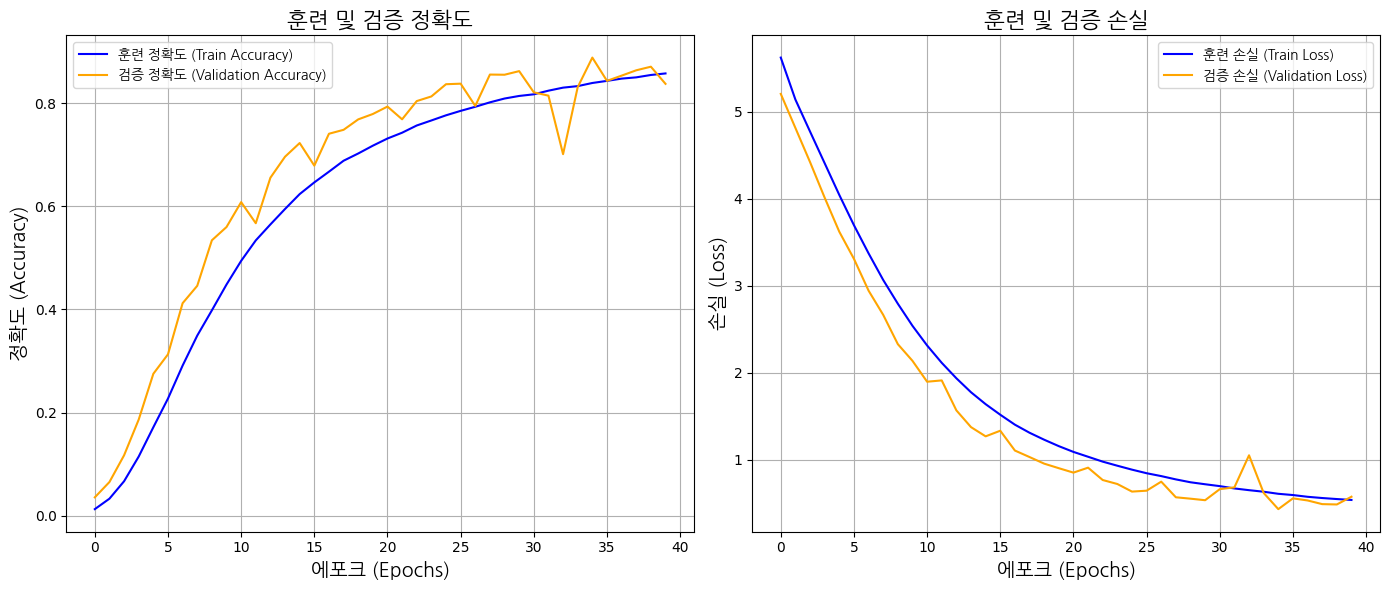

모든 작업이 완료되었습니다.


In [19]:

from sklearn.metrics import confusion_matrix, classification_report
# -----------------------------
# 12. 결과 시각화
# -----------------------------
print("결과를 시각화 중...")

import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# NanumGothic 폰트 경로 확인
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 설정
font_prop = font_manager.FontProperties(fname=font_path)

# b. 분류 보고서
print("분류 보고서를 출력합니다:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

# c. 학습 기록 시각화
print("학습 기록을 시각화합니다...")
plt.figure(figsize=(14, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='훈련 정확도 (Train Accuracy)', color='blue')
plt.plot(history.history['val_accuracy'], label='검증 정확도 (Validation Accuracy)', color='orange')
plt.title('훈련 및 검증 정확도', fontproperties=font_prop, fontsize=16)
plt.xlabel('에포크 (Epochs)', fontproperties=font_prop, fontsize=14)
plt.ylabel('정확도 (Accuracy)', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='훈련 손실 (Train Loss)', color='blue')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)', color='orange')
plt.title('훈련 및 검증 손실', fontproperties=font_prop, fontsize=16)
plt.xlabel('에포크 (Epochs)', fontproperties=font_prop, fontsize=14)
plt.ylabel('손실 (Loss)', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)

plt.tight_layout()
plt.show()

print("모든 작업이 완료되었습니다.")


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# -----------------------------
# Transformer 모델 정의 함수
# -----------------------------
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    """
    Transformer 블록: Multi-Head Attention + FeedForward Layer
    """
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual Connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed Forward Layer
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attention_output, ff_output])  # Residual Connection
    output = LayerNormalization(epsilon=1e-6)(ff_output)

    return output

# -----------------------------
# Transformer 모델 구축
# -----------------------------
def build_transformer(input_shape, num_classes, num_heads=8, ff_dim=64, num_layers=2):
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_layers):  # 여러 개의 Transformer 블록 쌓기
        x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim)

    # GlobalAveragePooling1D로 시퀀스를 평균값으로 압축
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)  # Dense Layer
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)  # 출력 Layer

    model = Model(inputs=inputs, outputs=x)
    return model

# -----------------------------
# 모델 학습 설정
# -----------------------------
input_shape = (None, X_train.shape[2])  # (timesteps, features)
num_classes = y_train.shape[1]  # 클래스 개수

# 모델 생성
print("Transformer 모델을 구축 중...")
transformer_model = build_transformer(input_shape, num_classes, num_heads=8, ff_dim=128, num_layers=1)

# 모델 컴파일
transformer_model.compile(optimizer=Adam(learning_rate=0.0003),
                          loss='categorical_crossentropy',  # 원-핫 인코딩된 라벨을 사용 시
                          metrics=['accuracy'])

# 모델 요약
transformer_model.summary()

# -----------------------------
# 콜백 함수 설정
# -----------------------------
callbacks = [
    ModelCheckpoint("best_transformer_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

# -----------------------------
# 모델 학습
# -----------------------------
print("Transformer 모델 학습 시작...")
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# 모델 학습 후 세션 초기화
tf.keras.backend.clear_session()
print("TensorFlow 세션 초기화 완료. GPU 메모리가 해제되었습니다.")


Transformer 모델을 구축 중...


I0000 00:00:1734470998.439766  159352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734470998.626324  159352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734470998.626386  159352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734470998.630767  159352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734470998.630835  159352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 225) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 225) │  1,625,625 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 225) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 225) │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 225) │        450 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 128) │     28,928 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 225) │     29,025 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 225) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 225) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 225) │        450 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 225)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     28,928 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 321)       │     41,409 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,754,815 (6.69 MB)

 Trainable params: 1,754,815 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

Transformer 모델 학습 시작...
Epoch 1/100


I0000 00:00:1734471007.322245  188612 service.cc:146] XLA service 0x7fdc08024740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734471007.322312  188612 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-18 06:30:07.391700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 06:30:07.835970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-18 06:30:10.126351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 28 bytes spill stores, 28 bytes spill loads

2024-12-18 06:30:10.513410: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory 

   2/1557 ━━━━━━━━━━━━━━━━━━━━ 2:08 83ms/step - accuracy: 0.0000e+00 - loss: 5.9553  

I0000 00:00:1734471026.975717  188612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1551/1557 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0138 - loss: 5.4810

2024-12-18 06:30:45.844084: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 20 bytes spill stores, 20 bytes spill loads

2024-12-18 06:30:46.407840: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 316 bytes spill stores, 316 bytes spill loads

2024-12-18 06:30:47.636822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 108 bytes spill stores, 108 bytes spill loads

2024-12-18 06:30:47.779015: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 260 bytes spill stores, 260 bytes spill loads

2024-12-18 06:30:47.824626: I external/local_xla/xla/stream_execu

1557/1557 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0139 - loss: 5.4796

2024-12-18 06:31:03.845470: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 44 bytes spill stores, 44 bytes spill loads

2024-12-18 06:31:03.867542: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 4 bytes spill stores, 4 bytes spill loads

2024-12-18 06:31:03.960974: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 36 bytes spill stores, 36 bytes spill loads

2024-12-18 06:31:04.795533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 176 bytes spill stores, 180 bytes spill loads

2024-12-18 06:31:05.698307: I external/local_xla/xla/stream_executor/cud

1557/1557 ━━━━━━━━━━━━━━━━━━━━ 63s 26ms/step - accuracy: 0.0139 - loss: 5.4793 - val_accuracy: 0.0787 - val_loss: 4.2177
Epoch 2/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.0725 - loss: 4.2649 - val_accuracy: 0.1594 - val_loss: 3.5491
Epoch 3/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.1281 - loss: 3.7158 - val_accuracy: 0.2596 - val_loss: 2.9976
Epoch 4/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2071 - loss: 3.2207 - val_accuracy: 0.3647 - val_loss: 2.4861
Epoch 5/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2818 - loss: 2.7993 - val_accuracy: 0.4172 - val_loss: 2.1600
Epoch 6/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3424 - loss: 2.4582 - val_accuracy: 0.4955 - val_loss: 1.8366
Epoch 7/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3940 - loss: 2.2074 - val_accuracy: 0.5367 - val_loss: 1.6501
Epoch 8/100
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.4456 - los

In [16]:
from tensorflow.keras.models import load_model
# -----------------------------
# 11. 모델 평가
# -----------------------------

print("베스트 모델을 로드 중...")
# 학습된 베스트 모델 불러오기
model = load_model(r'/mnt/c/Users/SBS/Desktop/WorkSpace/SignLanguageModel/tmp/best_transformer_model.keras')
print("베스트 모델이 성공적으로 로드되었습니다.")

import numpy as np

# 모델 예측
y_pred = model.predict(X_test)  # 클래스별 확률값 반환

# 각 샘플에서 가장 확률이 높은 클래스 인덱스 찾기
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 라벨 인덱스 (원-핫 인코딩된 y_test를 다시 클래스 인덱스로 변환)
y_true_classes = np.argmax(y_test, axis=1)

# 출력 확인
print("예측된 클래스 인덱스:", y_pred_classes[:10])
print("실제 클래스 인덱스:", y_true_classes[:10])

베스트 모델을 로드 중...
베스트 모델이 성공적으로 로드되었습니다.
402/402 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
예측된 클래스 인덱스: [242 178 163 158 136   2  14  97 252  36]
실제 클래스 인덱스: [140 133 163 158 136 195  14  97 252  36]


결과를 시각화 중...
분류 보고서를 출력합니다:
              precision    recall  f1-score   support

        알려주다       0.95      1.00      0.98        40
           1       0.92      0.55      0.69        40
         10분       0.62      0.82      0.71        40
         119       0.93      0.95      0.94        40
          12       0.65      0.55      0.59        40
         12시       0.86      0.93      0.89        40
          1시       0.91      1.00      0.95        40
         1시간       0.93      1.00      0.96        40
          1호       0.78      0.72      0.75        40
          1회       0.76      0.93      0.83        40
          2호       0.90      0.95      0.93        40
           3       0.97      0.90      0.94        40
          3시       0.97      0.93      0.95        40
          3호       0.87      1.00      0.93        40
         40분       0.72      0.72      0.72        40
         4사람       0.93      0.95      0.94        40
         50분       0.92      0.90      0.91        40

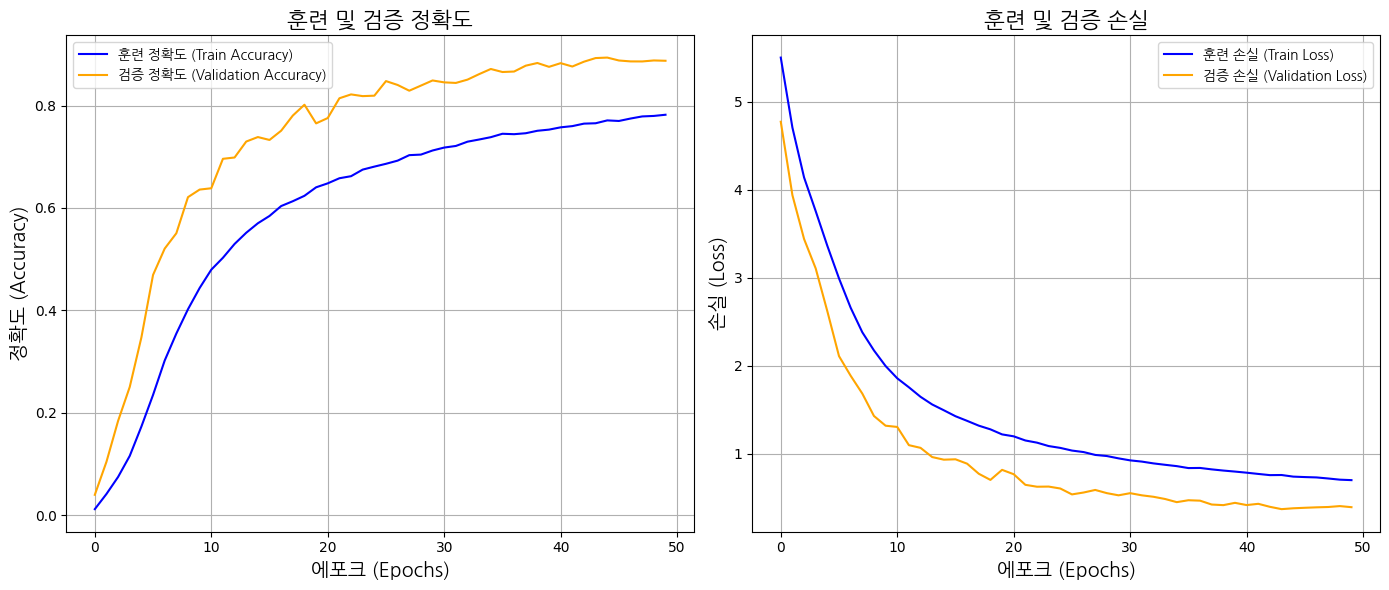

모든 작업이 완료되었습니다.


In [17]:

from sklearn.metrics import confusion_matrix, classification_report
# -----------------------------
# 12. 결과 시각화
# -----------------------------
print("결과를 시각화 중...")

import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# NanumGothic 폰트 경로 확인
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 설정
font_prop = font_manager.FontProperties(fname=font_path)

# b. 분류 보고서
print("분류 보고서를 출력합니다:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

# c. 학습 기록 시각화
print("학습 기록을 시각화합니다...")
plt.figure(figsize=(14, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='훈련 정확도 (Train Accuracy)', color='blue')
plt.plot(history.history['val_accuracy'], label='검증 정확도 (Validation Accuracy)', color='orange')
plt.title('훈련 및 검증 정확도', fontproperties=font_prop, fontsize=16)
plt.xlabel('에포크 (Epochs)', fontproperties=font_prop, fontsize=14)
plt.ylabel('정확도 (Accuracy)', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='훈련 손실 (Train Loss)', color='blue')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)', color='orange')
plt.title('훈련 및 검증 손실', fontproperties=font_prop, fontsize=16)
plt.xlabel('에포크 (Epochs)', fontproperties=font_prop, fontsize=14)
plt.ylabel('손실 (Loss)', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)

plt.tight_layout()
plt.show()

print("모든 작업이 완료되었습니다.")


In [8]:
# GPU 메모리 초기화 함수
# 모델 학습 후 세션 초기화
tf.keras.backend.clear_session()
print("TensorFlow 세션 초기화 완료. GPU 메모리가 해제되었습니다.")

TensorFlow 세션 초기화 완료. GPU 메모리가 해제되었습니다.


In [ ]:
import gc

# 가비지 컬렉션 강제 실행
gc.collect()
